<!-- # made some changes change in environment:
add statsmodels, seaborn  to pip install 
1. [x] Introduction about the dynamic foraging task (Jeremiah just has half an hour lecture so maybe we need some explanation or some figures to explain the mechanism) [Shuchen]
2. [x] Introduction about generative model, [x] R-W rule [ ] winstayloseshift[Shuchen], and how this code simulates data
3. [x] Why and how to perform model simulation [Shuchen]
4. [x] How to perform model fitting and parameter recovery [Shuchen]
5. [] make things more coherent, check what else would be needed
6. [x] getting more parameter recovery plots, to make the process more intuitive?
7. [x] I do not understand how the simple win-stay-lose-shift translate to Han's code
    - I THINK the code could only implement a non-noisy WSLS model [Yusi]
8. [x] Let's show a parameter recovery plot for RW1972 
9. [x] And also a model comparison plot between a number of models
10/. [x] clean up some code in the util function
11. [x] add explanations of the code class [Yusi]
12. [x] Do we nned to combine env./agent simulation code with the text explanation at the beginning? [Yusi]
13. [x] add exercise problems [Yusi]
 -->

<img src="./resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">DAY 3 Workshop SWDB 2025 </h1> 
<h3 align="center">Wednesday, August 27th, 2025</h3> 
<h3 align="center">Fiting Models on Behavioral Data</h3> 

Behavioral data typically consist of choices, Reaction times, Eye movements, and sometimes Neural signals. Computational models instantiate algorithmic hypotheses about the processes that generate behavior. Fitting computational models to behavioral data allows us to probe the algorithms underlying behavior and test mechanistic hypotheses about the mind. Thereby, we can use precise mathematical models to make sense of rich behavioral data.

Model fitting is a powerful tool for making cognitive theories explicit, testable, and quantitatively precise. It typically involves:

1. **Simulation** – to understand what the model predicts.
2. **Parameter estimation** – to fit the model to data.
3. **Model comparison** – to evaluate competing hypotheses.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

__Objectives of this tutorial__
    
-understand computational algorithms governing observed behavior

-recover these algorithms by model fitting and model comparison

-identify computational algorithms used by mice in the Dynamic Foraging task

</div>


## Refresh: The Dynamic Foraging Task

From flies to primates, all animals must learn about their environment, search for resources, and make adaptive decisions. Foraging—the process of selecting actions to obtain rewards—is a behavior conserved across a wide range of species.

The **dynamic foraging task** provides a simple paradigm for studying this behavior. In this task, a head-fixed mouse hears a "go cue" signaling the opportunity to perform one of two possible actions: **licking left** or **licking right**.

Unbeknownst to the animal, the **probability of receiving a water reward** for licking left or right fluctuates over time. Thus, the animal must learn to infer which action is more rewarding under changing contingencies.

---

## Model 1: Rescorla-Wagner Softmax

We introduce **Q-learning**, a reinforcement learning model that estimates the expected value of each action and updates those estimates based on **reward prediction errors** (RPEs) (Bertsekas & Tsitsiklis, 1996; Sutton & Barto, 1998). This model captures how action values are incrementally adjusted over time and allows us to compute trial-by-trial RPEs. A classic model of such learning is the **Rescorla-Wagner rule** (Rescorla & Wagner, 1972). In this model, the expected value of each action is updated based on the discrepancy between received and expected outcomes. Specifically, the value of option $L$ on trial $t$, denoted $Q^L_t$, is updated according to:

$$
Q^L_{t+1} = Q^L_t + \alpha C^L_t (r_t - Q^L_t)
$$

Here:
- $C^L_t \in \{0,1\}$ is an indicator function of choosing left on trial $t$ 
- $r_t \in \{0,1\}$ is the reward on trial $t$,
- $\alpha \in [0, 1]$ is the **learning rate**, controlling how strongly the prediction error $(r_t - Q^L_t)$ updates the value,
- $Q^L_0$ is typically initialized to zero or treated as a free parameter.

To translate learned values into choices, we use the **softmax decision rule**, which models the stochastic selection of actions based on their values. The probability of choosing action $k$ is given by:

$$
p^L_t = \frac{\exp(\sigma Q^L_t)}{\exp(\sigma Q^L_t) + \exp(\sigma Q^R_t)}
$$

$\sigma$ is the **inverse temperature** parameter. Higher $\sigma$ leads to more deterministic (greedy) choices, while lower $\sigma$ encourages more exploratory behavior. The model is parameterized by:
$
\boldsymbol{\theta} = (\alpha, \sigma)
$


## Model 1 Variant: Epsilon Greedy Algorithm 

Another way to choose the decision is using an $\epsilon$ parameter to balance exploration versus exploitation. The action $c_t$ at trial $t$ becomes, with probability $\epsilon$, select a random action (exploration); with probability $1 - \epsilon$, select the action with the highest Q-value (exploitation).


$$
c_t =
\begin{cases}
\text{random action}, & \text{with probability } \epsilon \\
\arg\max_k Q(k), & \text{with probability } 1 - \epsilon
\end{cases}
$$

<!-- $$
\pi(c_t = k) =
\begin{cases}
\frac{\epsilon}{K}, & \text{if } k \neq \arg\max_j Q^j_t \\
1 - \epsilon + \frac{\epsilon}{K}, & \text{if } k = \arg\max_j Q^j_t
\end{cases}
$$ -->

The model is parameterized by:
$
\boldsymbol{\theta} = (\alpha, \epsilon)
$
<!-- 
The parameter \( \epsilon \) controls the exploration-exploitation trade-off: A small \( \epsilon \) (e.g., 0.1) means mostly exploiting the best-known action with occasional exploration. A larger \( \epsilon \) (e.g., 0.5) encourages more exploration, with less focus on exploitation. -->

---

## Model 2: Biased Win-Stay Lose-Shift 

The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.

The idea is: if the agent received a reward for choosing an action on the previous trial (a win), it repeats that action; if the agent did not receive a reward (a loss), it switches to the alternative action on the next trial.

To take account of the agent's preferrance of one decision over another, a bias parameter appends to the binary count of the reward, which is then normalized to be the probability of choosing one arm over the other. 


The model is parameterized by:
$
\boldsymbol{\theta} = (bias_L)$

<div align="center">

**List all outcomes:**

| Previous Choice | Previous Reward | Probability of Choosing L at $t$ |
|-----------------|----------------|:--------------------------------:|
| $c_{t-1} = L$   | $r_{t-1} = 1$  | $ \frac{bias_L + 1}{bias_L + 1}$ = 1 |
| $c_{t-1} = L$   | $r_{t-1} = 0$  | $\frac{bias_L}{bias_L + 1}$               |
| $c_{t-1} = R$   | $r_{t-1} = 1$  | $\frac{bias_L}{bias_L + 1}$               |
| $c_{t-1} = R$   | $r_{t-1} = 0$  | $\frac{bias_L + 1}{bias_L + 1}$ = 1 |

</div>



## Model 2 Variant: Loss Counting with Probabilistic Threshold

A more general variant of the win-stay lose-shift model is loss counting with a probabilistic threshold. The model switches arms when the count of loss (no reward) $\ell_t$ from one arm exceed a (stochastic) loss threshold $\tau_t$ with mean $\mu_{LC}$ and variance $\sigma_{LC}$. 

Action switches when 
$$
l_t \ge \tau_t
$$

Redraw threshold when switching
$$
\tau_{t+1} \sim \mathcal{N}(\mu_{LC},\sigma_{LC}^2) 
$$


The model is parameterized by:
$
\boldsymbol{\theta} = (\mu_{LC},\sigma_{LC})
$

-----

## Summary Table

| Model Name                | Description                                                                 | Parameters $\theta$                                                                                  |
|---------------------------|-----------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| Rescorla-Wagner Softmax   | Q-learning with value update via RPE and softmax action selection           | $\alpha$ (learning rate), $\sigma$ (inverse temperature)    |
| RW1972 Epsilon-Greedy     | Q-learning with value update and $\epsilon$-greedy action selection         | $\alpha$ (learning rate), $\epsilon$ (exploration rate)  |
| Biased Win-Stay Lose-Shift| Repeat rewarded action, switch after loss, with bias                        | $bias_L$                                                                                     |
| Loss Counting             | Switch when consecutive losses exceed stochastic threshold                  | $\mu_{LC}$ (mean threshold), $\sigma_{LC}$ (threshold std)  |

**Parameter Notations:**  
- $\alpha$: learning rate  
- $\sigma$: inverse temperature (softmax)  
- $\epsilon$: exploration rate  
- $bias_L$, $bias_R$: left/right bias  
- $\mu_{LC}$, $\sigma_{LC}$: loss counting threshold mean/std  

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import UncoupledBlockTask
from utils_model_recovery import *
import multiprocessing as mp
import matplotlib.pyplot as plt


# Simulation:

Once you have an experimental design and a set of computational models, a really important step is to create fake, or surrogate data. That is, you should use the models to simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment. 

Simulation involves running an artificial agent — here, performing the dynamic foraging task — with specified parameters to generate synthetic behavioral data. These surrogate datasets can be analyzed like real data to visualize expected behavior under different assumptions, evaluate the impact of model parameters, test experimental design sensitivity, and generate falsifiable predictions.

### Environment initialization
First we want to initialize a world environment which will interact with the agent to give feedback, including reward/force switch etc. This is like the rules for the task. The `UncoupledBlockTask` is a wrapped environment where reward probabilities for each action (e.g., left or right) change **independently** across blocks of trials.

<details>
<summary><b> Class UncoupledBlockTask explained </b></summary>

**Overview**

- The `UncoupledBlockTask` class implements a dynamic foraging environment where reward probabilities for left and right choices change **independently** across blocks of trials.

**Initialization Arguments**
- `reward_baiting`: `bool = False`
  - Whether rewards persist until collected
  - `True`: Uncollected rewards remain available
  - `False`: Rewards are generated fresh each trial

- `allow_ignore`: `bool = False`
  - Whether agent can skip trials
  - `True`: Adds "ignore" as third action option
  - `False`: Agent must choose left or right

- `num_arms`: `int = 2`
  - Number of choice options (typically 2 for left/right)

- `num_trials`: `int = 1000`
  - Total number of trials in the session

- `seed`: `int = None`
  - Random seed for reproducibility

- `rwd_prob_array`: `List[float] = [0.1, 0.5, 0.9]`
  - Available reward probabilities for block assignment
  - Each new block randomly selects from this array

- `block_min`: `int = 20`
  - Minimum block length in trials

- `block_max`: `int = 35`
  - Maximum block length in trials

- `persev_add`: `bool = True`
  - Enable anti-perseveration mechanism

- `perseverative_limit`: `int = 4`
  - Number of consecutive choices on min-prob side to trigger anti-persev

- `max_blocc_tally`: `int = 4`
  - Maximum consecutive blocks one side can be better before forced balancing

**Key Methods**

- `reset()`: Initialize new session with fresh block schedule
- `step(action)`: Execute one trial and return (observation, reward, done, info)
- `generate_new_trial()`: Create reward probabilities for next trial
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data
- `get_p_reward()`: Get reward probability matrix for analysis
- `plot_reward_schedule()`: Visualize block structure and choice patterns


</details>

In [10]:
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)

### Agent initialization

Next we want to initialize an agent which will interact with the task environment following its internal algorithm such as Q-learning. `ForagerQLearning` is a sophisticated reinforcement learning agent that implements Q-learning for dynamic foraging tasks. 


<details>
<summary><b> class ForagerQLearning explained </b></summary>

**Overview:**

The `ForagerQLearning` class is a flexible reinforcement learning agent that incrementally updates action-value estimates (Q-values) based on reward history, supports different learning rates/forget rates for rewarded versus unrewarded outcomes, and can incorporate choice history effects through choice kernels. 

**Initialization configs:**
- `number_of_learning_rate`: `Literal[1, 2] = 2`
  - Controls learning rate structure
  - `1`: Single learning rate for all outcomes
  - `2`: Separate rates for rewarded (`learn_rate_rew`) and unrewarded (`learn_rate_unrew`) outcomes

- `number_of_forget_rate`: `Literal[0, 1] = 1`
  - Controls forgetting mechanism
  - `0`: No forgetting of unchosen options
  - `1`: Includes `forget_rate_unchosen` parameter

- `choice_kernel`: `Literal["none", "one_step", "full"] = "none"`
  - Choice history influence on decisions
  - `"none"`: No choice history effects
  - `"one_step"`: Only immediate previous choice (Bari2019 style)
  - `"full"`: Exponentially weighted choice history with learnable parameters

- `action_selection`: `Literal["softmax", "epsilon-greedy"] = "softmax"`
  - Decision strategy
  - `"softmax"`: Probabilistic selection with inverse temperature parameter
  - `"epsilon-greedy"`: Exploration with fixed epsilon probability

- `params`: `dict = {}`
  - Initial model parameters (auto-generated based on configuration)
  - Learning rates: `learn_rate`, `learn_rate_rew`, `learn_rate_unrew` (0.0-1.0)
  - Forget rates: `forget_rate_unchosen` (0.0-1.0)
  - Bias: `biasL` (left side bias, -5.0 to 5.0)
  - Action selection: `softmax_inverse_temperature` (0.0-100.0) or `epsilon` (0.0-1.0)
  - Choice kernel: `choice_kernel_relative_weight`, `choice_kernel_step_size` (0.0-1.0)

- `**kwargs`: Additional arguments passed to base class (e.g., `seed` for reproducibility)

**Key Methods:**

- `perform(task)`: Simulate agent behavior on a foraging task
- `fit(choice_history, reward_history)`: Fit model parameters to behavioral data
- `act(observation)`: Select action based on current Q-values
- `learn(observation, action, reward, next_observation, done)`: Update Q-values after action
- `plot_session()`: Visualize behavioral session and internal states
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data

</details>

In [3]:
forager = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")

**Exercise**: describe this Q-learning model

1. How is the learning rate going to be updated? Same for all choices or differentiate between rewarded and unrewarded choices?
2. What is the forget mechanism? 
3. Is previous choice going to influece the choice structure? 
4. What is the decision strategy? 
5. What are the parameters associated? 

<details>
<summary><b> Answer </b></summary>

1. Same learning rate for all choices
2. No forgetting mechanism
3. No choice kernel
4. Epsilon-greedy decision strategy
5. Parameters: `forager.params`



### Agent interacting with task environment

In [4]:
# Simulate the model
forager.perform(task)

In [5]:
# obtain behaviorial data from the forager
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
print("Ground Truth Parameters:", ground_truth_params)
# Get the history
choice_history = forager.get_choice_history() # 0: Left, 1: Right
reward_history = forager.get_reward_history() # 0: Unrewarded, 1: Rewarded
p_reward = forager.task.get_p_reward() # row 0: Left, row 1: Right


Ground Truth Parameters: {'learn_rate': 0.5, 'biasL': 0.0, 'epsilon': 0.1}


#### Visualization of reward probability of two arms in the task

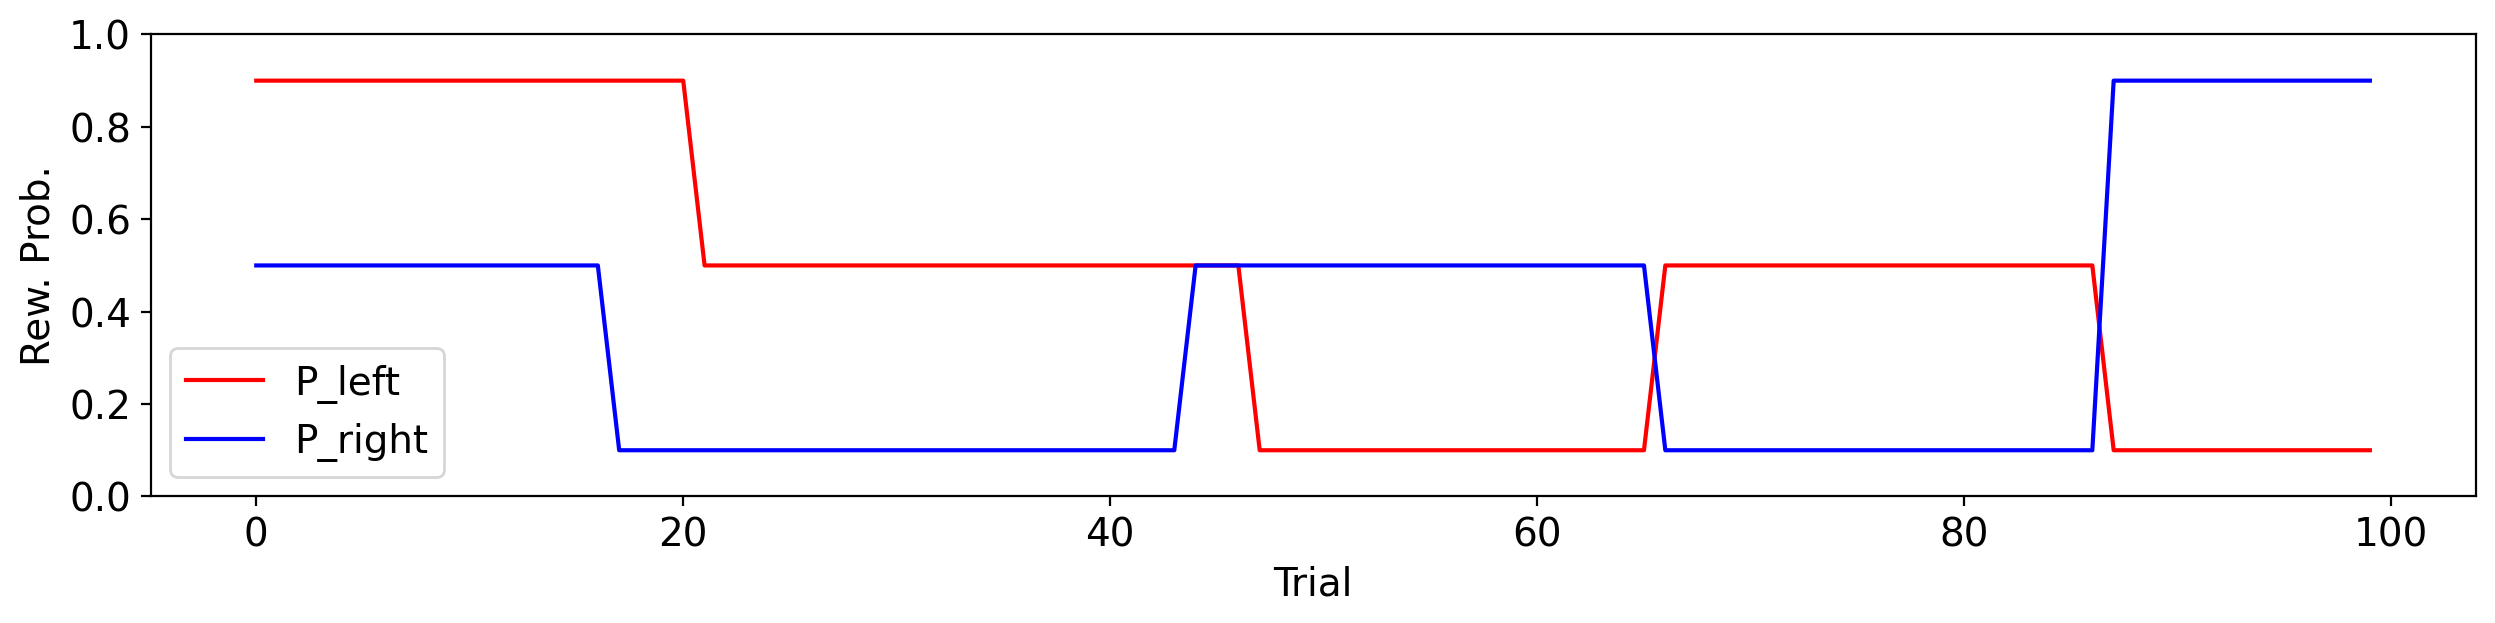

In [6]:
# reward probabilities fluctuate over trials between [0.1, 0.5, 0.9]
# print(np.unique(p_reward))
# visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)
ax.plot(task.get_p_reward()[0], label='P_left', color='red')
ax.plot(task.get_p_reward()[1], label='P_right', color='blue')
ax.set_ylim(0, 1)
ax.set_xlabel('Trial')
ax.set_ylabel('Rew. Prob.')
ax.legend()

#### Visualization choices by the simulated agent

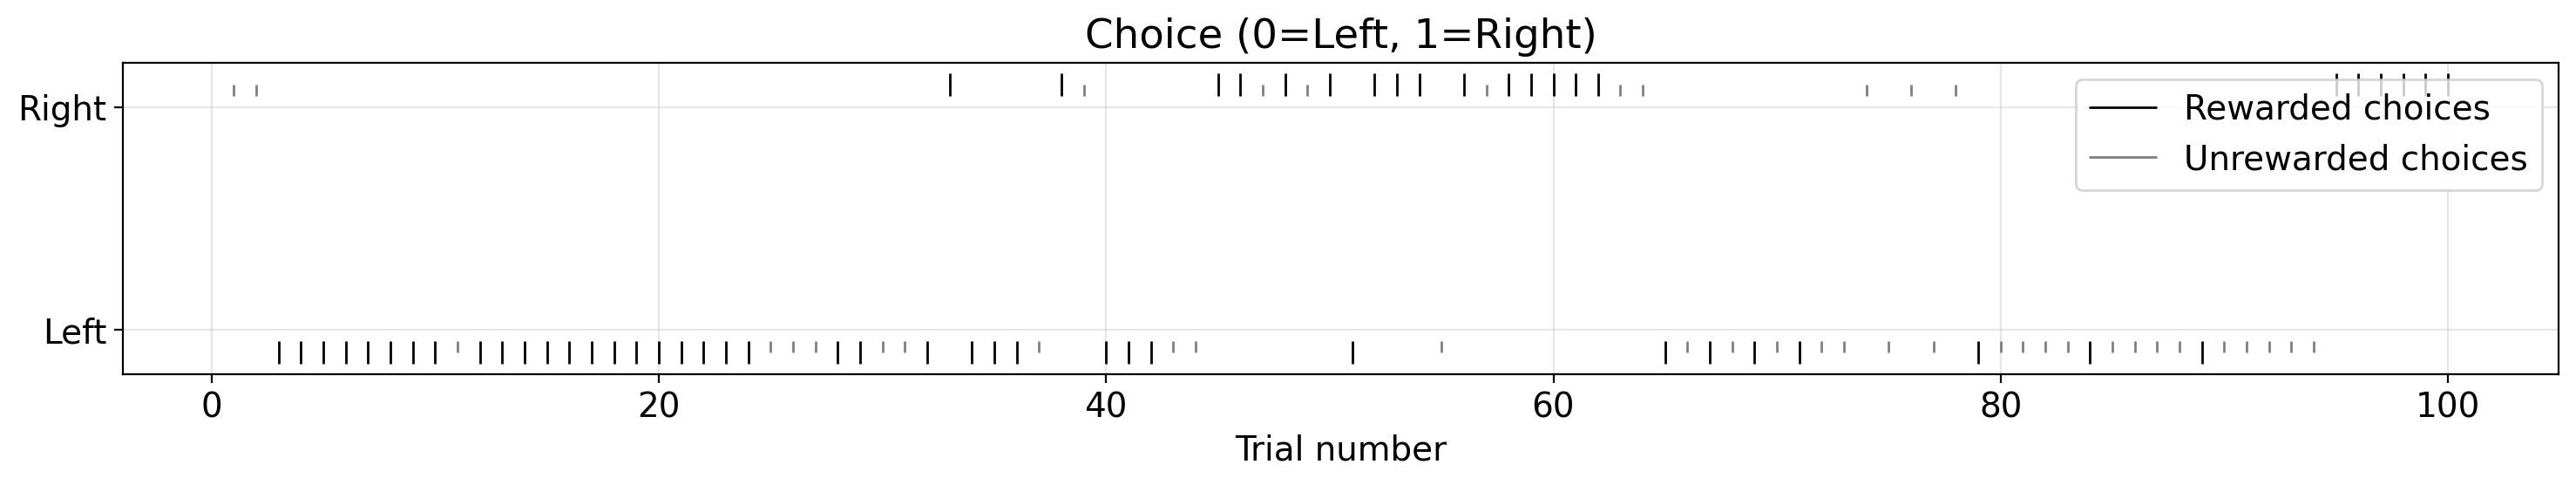

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)

rewarded_trials = reward_history == 1
unrewarded_trials = reward_history == 0
xx = np.nonzero(rewarded_trials)[0] + 1
yy_temp = choice_history[rewarded_trials]
yy_right = yy_temp[yy_temp > 0.5] + 0.05
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5] - 0.05
xx_left = xx[yy_temp < 0.5]

# Rewarded choices
ax.vlines(xx_right, yy_right, yy_right + 0.1, alpha=1, linewidth=1, color="black", label="Rewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left, alpha=1, linewidth=1, color="black")

unrewarded_trials = reward_history == 0
xx = np.nonzero(unrewarded_trials)[0] + 1
yy_temp = choice_history[unrewarded_trials]
yy_right = yy_temp[yy_temp > 0.5]
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5]
xx_left = xx[yy_temp < 0.5]

# Unrewarded choices
ax.vlines(xx_right, yy_right + 0.05, yy_right + 0.1, alpha=1, linewidth=1, color="gray", label="Unrewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left - 0.05, alpha=1, linewidth=1, color="gray")

# Set up axis labels and limits
ax.set_xlabel('Trial number')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Left', 'Right'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.title('Choice (0=Left, 1=Right)')
plt.tight_layout()
plt.show()

#### Visualization of choice statistics
1. Base reward probabilities = p_right / (p_right + p_left)
2. Choice = moving average of choice history, i.e. moving average of choosing right 
3. Q(L) (`ground_truth_q_value[0,:]`): ground truth q value for left choice
4. Q(R) (`ground_truth_q_value[1,:]`): ground truth q value for right choice
5. choice_prob(R/R+L) (`ground_truth_choice_prob[1] / ground_truth_choice_prob.sum(axis=0)`): choice probability normalized


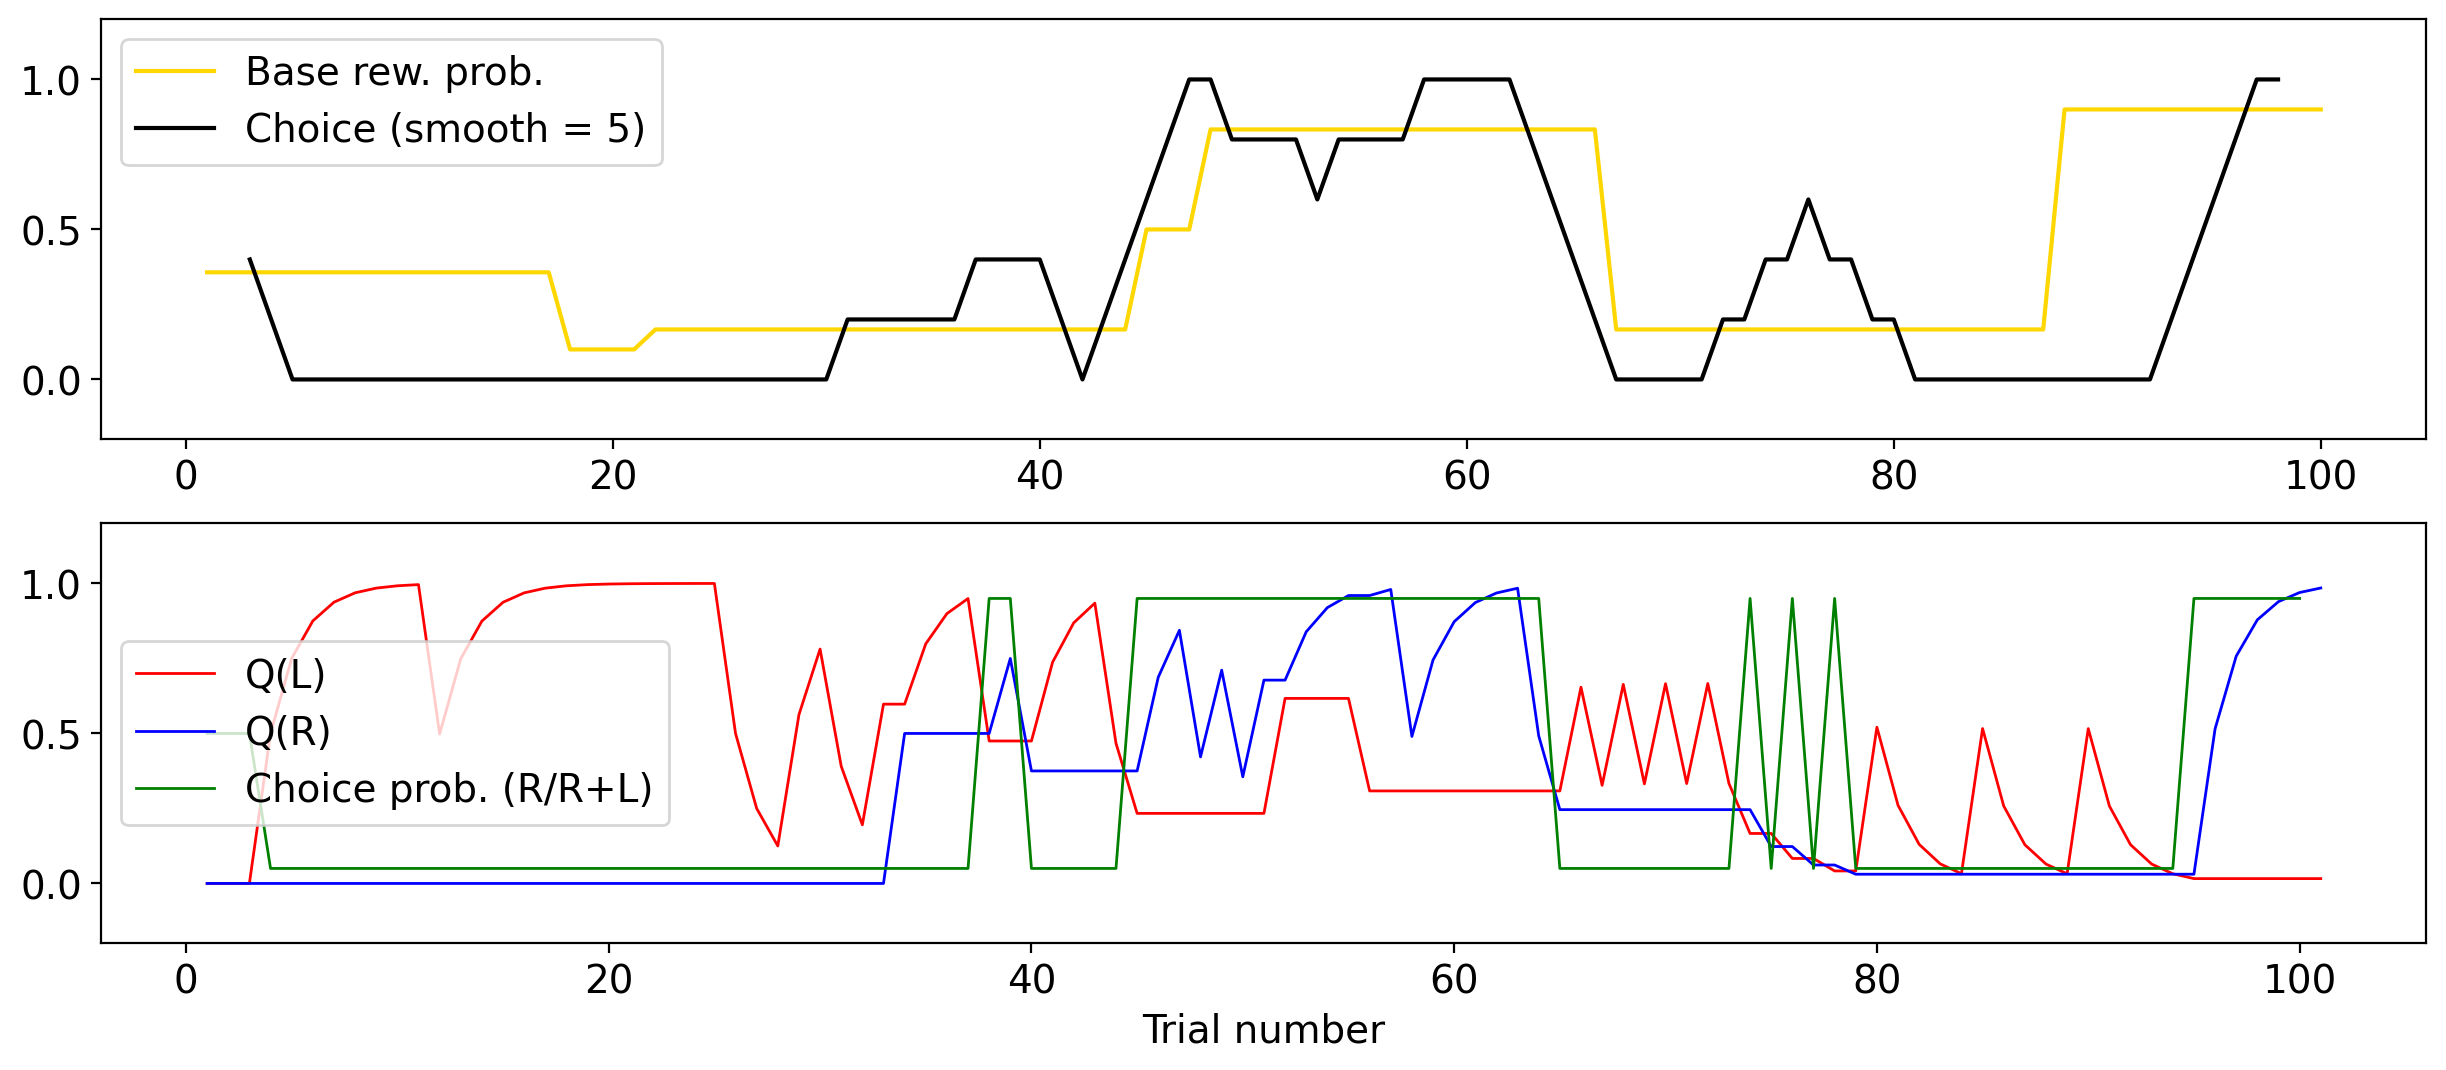

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), dpi=200)

def moving_average(a, n=3):
    """Compute moving average of a list or array."""
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n - 1):] / n

n_trials = len(choice_history)
smooth_factor = 5  

ax = axs[0]
ax.plot(np.arange(1,n_trials+1), p_reward[1, :] / (np.sum(p_reward, axis=0)),
         color="gold",label="Base rew. prob.",lw=1.5,)
y = moving_average(choice_history, n=smooth_factor)
ax.plot(np.arange(0, len(y)) + int(smooth_factor / 2) + 1, y,
        linewidth=1.5,color="black",label="Choice (smooth = %g)" % smooth_factor)
ax = axs[1]
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[0, :], lw=1, color="red", ls="-", label="Q(L)")
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[1, :], lw=1, color="blue", ls="-", label="Q(R)")
ax.plot(np.arange(1,n_trials+1), ground_truth_choice_prob[1] / np.sum(ground_truth_choice_prob, axis=0), lw=1, color="green", ls="-", label="Choice prob. (R/R+L)")

axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('Trial number')
axs[0].set_ylim(-0.2, 1.2)
axs[1].set_ylim(-0.2, 1.2)
plt.show()

Question: why are Q values fluctuctuating?

<details>
<summary><b> Answer </b></summary>
Baiting trials!
</details>

#### Visualization on one plot

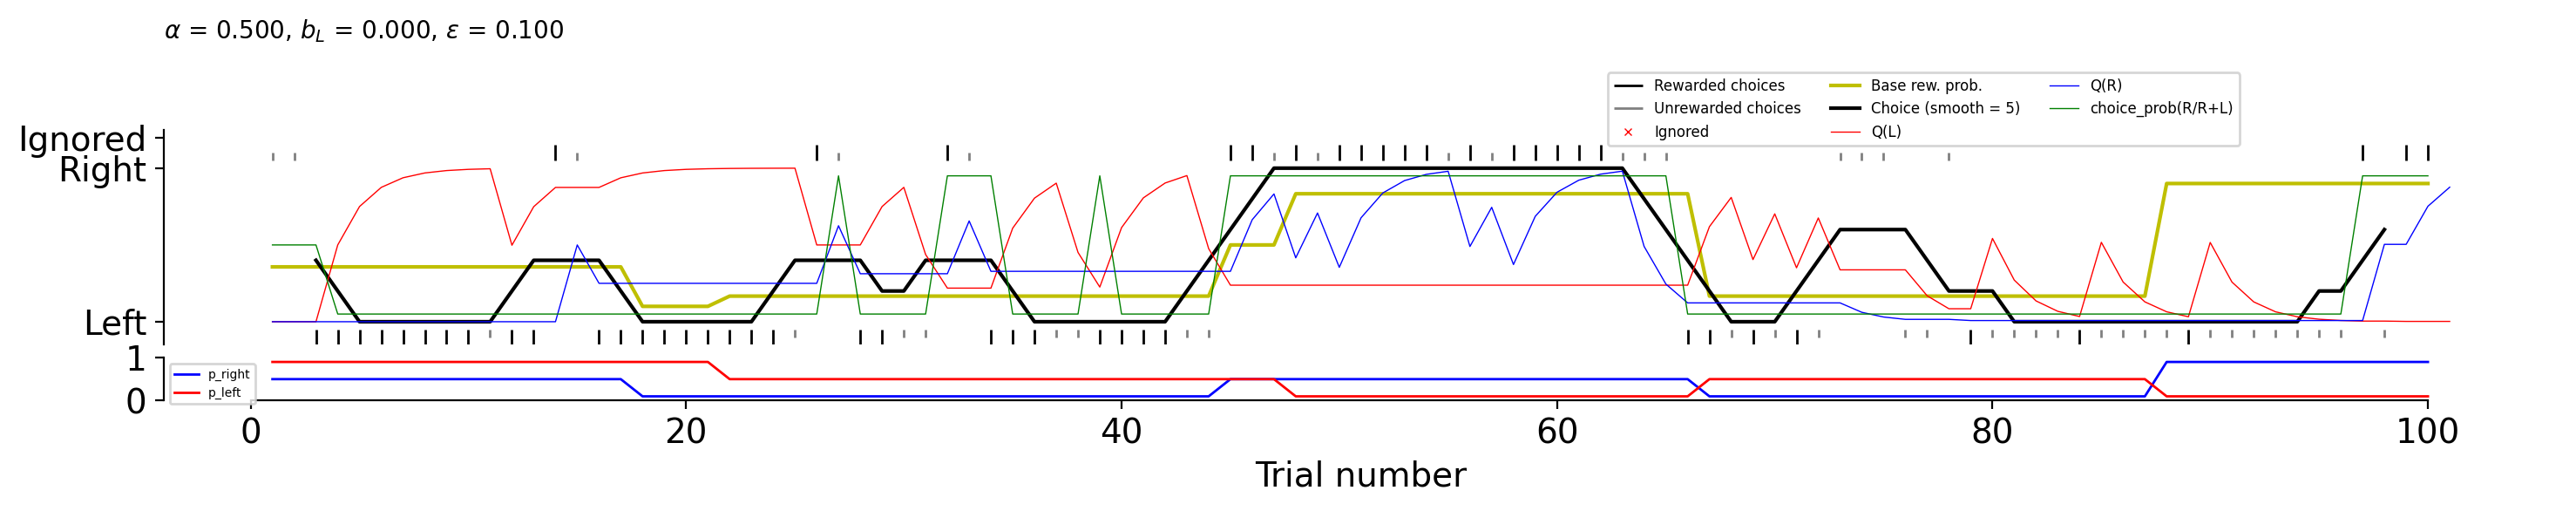

In [11]:
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery
Parameter estimation refers to **inferring model parameters** that best explain observed behavior.
Parameters are typically inferred using **maximum likelihood** or **Bayesian methods**.

### Maximum Likelihood

The observed data  $d_{1:T}$ includes **choice history** $c_t \in \{\text{L}, \text{R}\}$ and **reward history** $r_t \in \{0,1\}$
<!-- - **Reward history**: rewards associated with left and right actions:
  - $r_{R,t}$: reward received when choosing right at time $t$
  - $r_{L,t}$: reward received when choosing left at time $t$
 -->

To fit a model to behavioral data, we estimate the parameters $\boldsymbol{\theta}_M$ that maximize the likelihood of the observed data under model $M$. This is typically done using **maximum likelihood estimation (MLE)**:

$$
\hat{\boldsymbol{\theta}}^{\text{MLE}}_M = \arg\max_{\boldsymbol{\theta}_M} \log p(d_{1:T} \mid \boldsymbol{\theta}_M, M) = \arg\max_{\boldsymbol{\theta}_M} \sum_{t=1}^{T} \log p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$



### Example: RW epsilon greedy

Now we have access to the simulated agent's choices and environment feedback. How can we obtain the agent's parameter, which govern its choices from Q-learing model? We could utilize the `fit` function associated with `forager` class. 

<details>
<summary><b> forager.fit() explained </b></summary>

**Main purpose** 

Finds the model parameters that maximize the likelihood of observing the actual choice and reward history. Computes model evaluation metrics (AIC, BIC, prediction accuracy). Optionally cross-validation.

**Inputs** 
- `fit_choice_history` / `fit_reward_history`: Behavioral data to fit
- `clamp_params`: Fix specific parameters (e.g., `{"biasL": 0}`)
- `fit_bounds_override`: Custom parameter bounds for fitting
- `k_fold_cross_validation`: Number of CV folds (None = no CV)
- `DE_kwargs`: Optimization settings (workers, seed, etc.)

**Outputs**
- `fitting_result`: Best parameters, likelihood, AIC/BIC, prediction accuracy
- `fitting_result_cross_validaiton` (if requested): Test accuracies across folds


</details>


In [12]:
forager.fit(
    choice_history,
    reward_history,
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-08-12 13:34:31,447 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 15.46756976131556
differential_evolution step 2: f(x)= 15.46756976131556
differential_evolution step 3: f(x)= 15.46106375244661
differential_evolution step 4: f(x)= 15.46106375244661
differential_evolution step 5: f(x)= 15.46106375244661
differential_evolution step 6: f(x)= 15.46106375244661
differential_evolution step 7: f(x)= 15.46106375244661
differential_evolution step 8: f(x)= 15.46106375244661
differential_evolution step 9: f(x)= 15.46106375244661
differential_evolution step 10: f(x)= 15.46106375244661
differential_evolution step 11: f(x)= 15.46106375244661
Polishing solution with 'L-BFGS-B'


In [13]:
# Check fitting performance and results
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 100
Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.7880', '0.0619']
Likelihood-Per-Trial: 0.8567504435020521
Prediction accuracy full dataset: 0.95



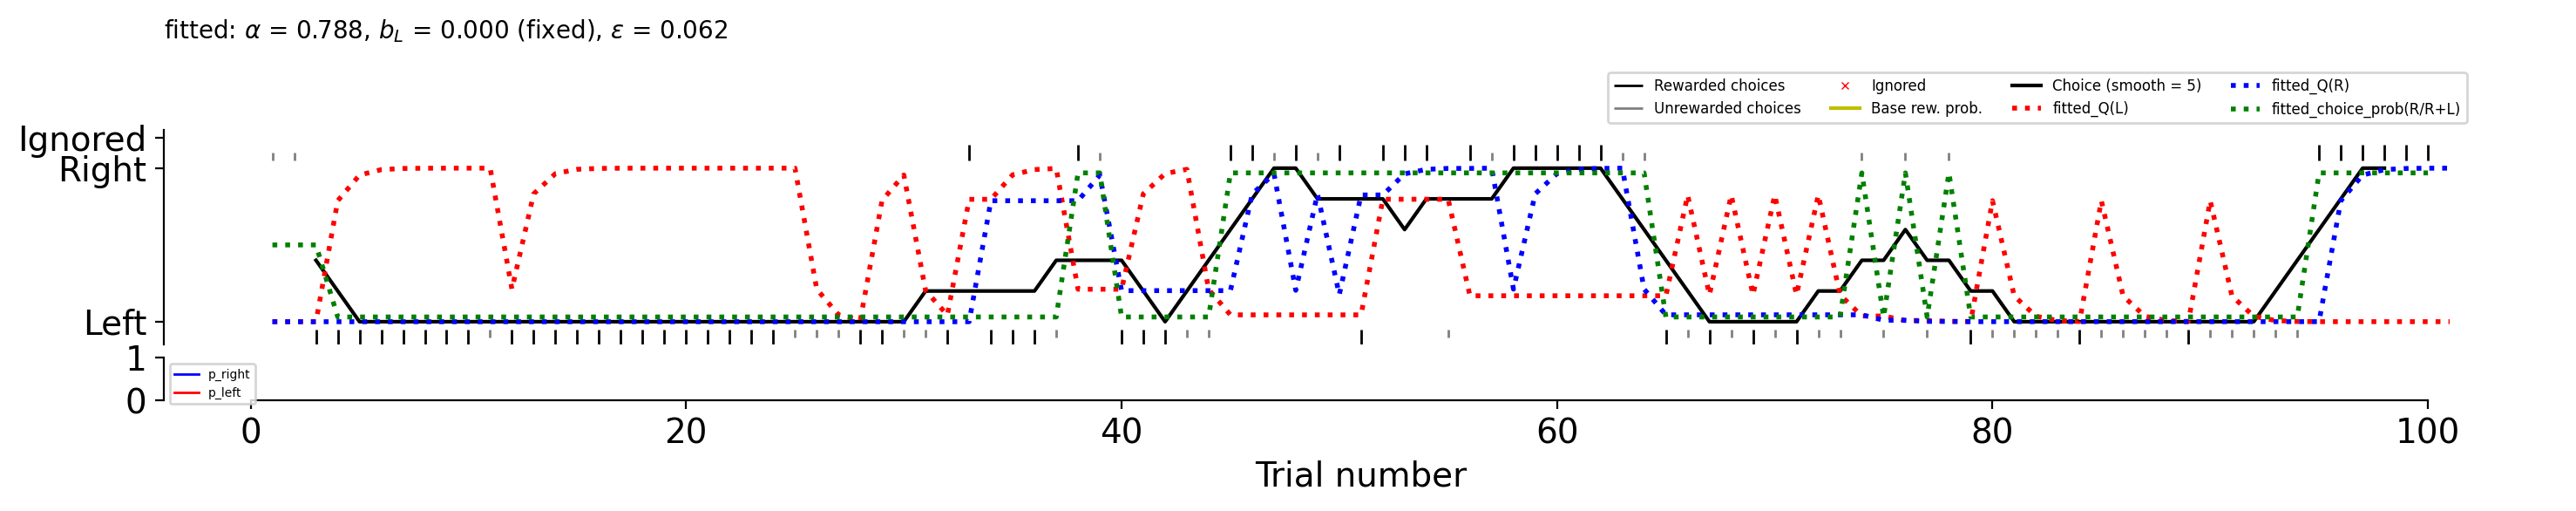

In [14]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

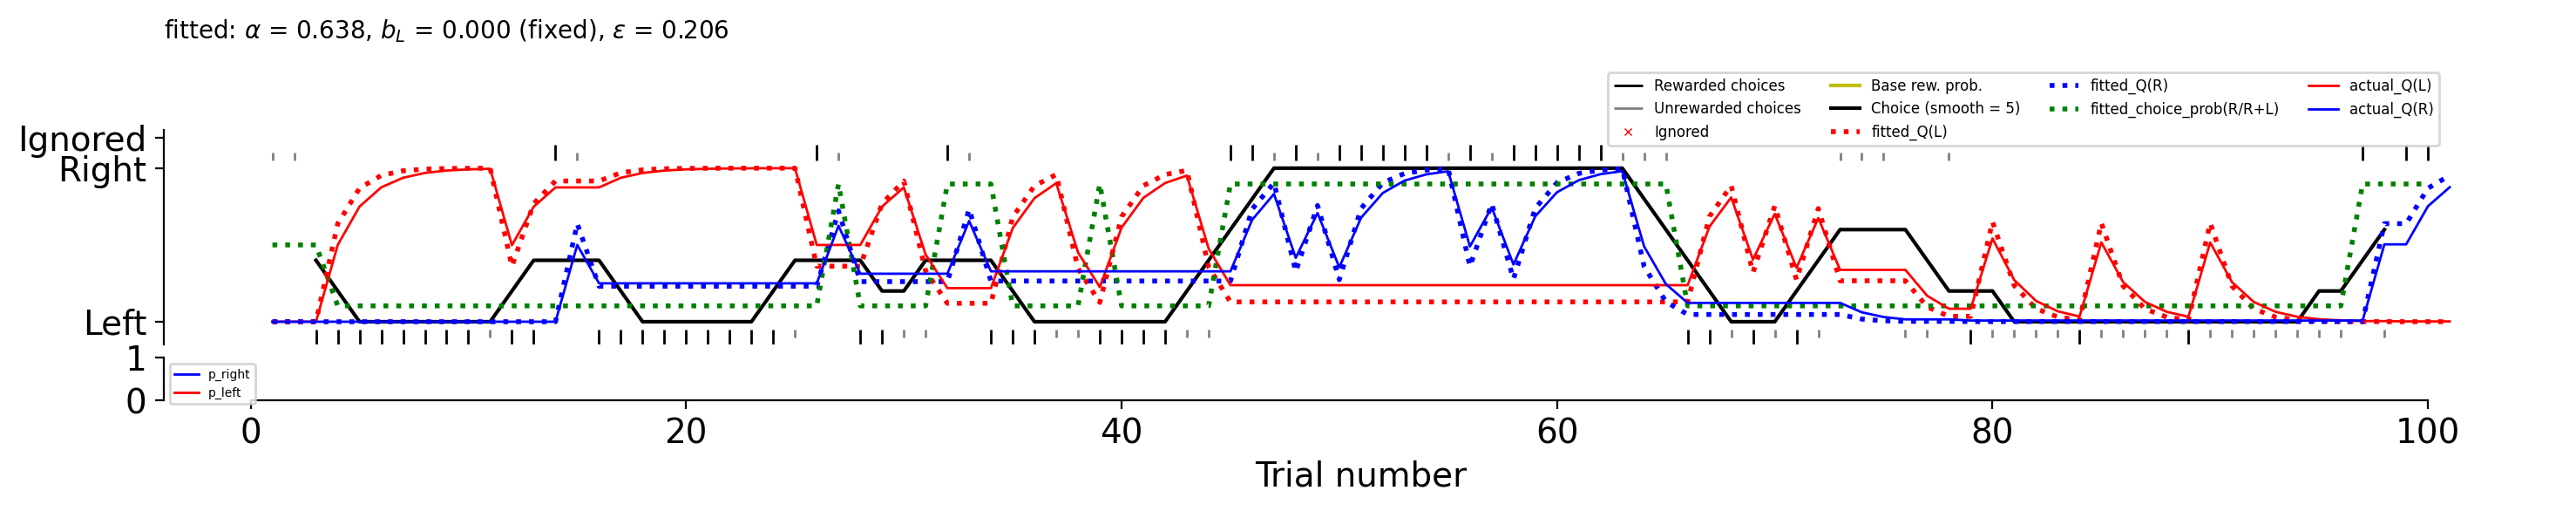

In [15]:
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)
xx = np.arange(1, len(ground_truth_q_value[0]) + 1)
axes[0].plot(xx, ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(xx, ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

**Question**: Why the inferred learning rate/epsilon don't match ground truth but the fitted latent variables still look the same? Can you resolve this?

<details>
<summary><b> Answer </b></summary>
Increasing trial numbers!
</details>



### Example: win-stay-lose-shift
<!-- 

The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.

In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of choosing option k is: 

Let $c_t \in \{1, 2\}$ be the choice at trial $t$, and $r_t \in \{0, 1\}$ the reward at trial $t$. Then:
 -->


Now let's initialize an artificial agent with biased 'win-stay-lose-shift' algorithm with `ForagerLossCounting` class

<details>
<summary><b> class ForagerLossCounting explained </b></summary>

**Overview:**

The `ForagerLossCounting` class implements a simple, psychologically plausible agent that uses a loss-counting strategy to decide when to switch actions in a dynamic foraging task. Instead of tracking action values, the agent counts consecutive unrewarded trials (losses) for the current choice. When the loss count exceeds a threshold, the agent switches to the other option.

**Inputs**
- `win_stay_lose_switch`: Boolean, enables classic win-stay-lose-shift logic (default True). If true, `loss_count_threshold_mean` and `loss_count_threshold_std` are fixed at 1 and 0
- `choice_kernel`: String, controls influence of choice history ("none", "one_step", "full").
- `params`: dictionary with following keys
    - `loss_count_threshold_mean`: Mean threshold for switching after losses.
    - `loss_count_threshold_std`: Standard deviation for threshold (adds stochasticity).
    - `biasL`: Optional bias toward left choice.

**Unique Attributes**
- `loss_count`: number of consecutive unrewarded trials

</details>

In [28]:
# initialize the task
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)
# initialize the forager with 'win-stay-lose-shift' algorithm
forager = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')
# fix some parameters
forager.set_params(biasL=0.1)  
# extract the parameters
forager.params.model_dump() # biasL term is not used here


{'loss_count_threshold_mean': 1.0,
 'loss_count_threshold_std': 0.0,
 'biasL': 0.1}

In [29]:
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_loss_count = forager.loss_count
ground_truth_choice_prob = forager.choice_prob

# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()


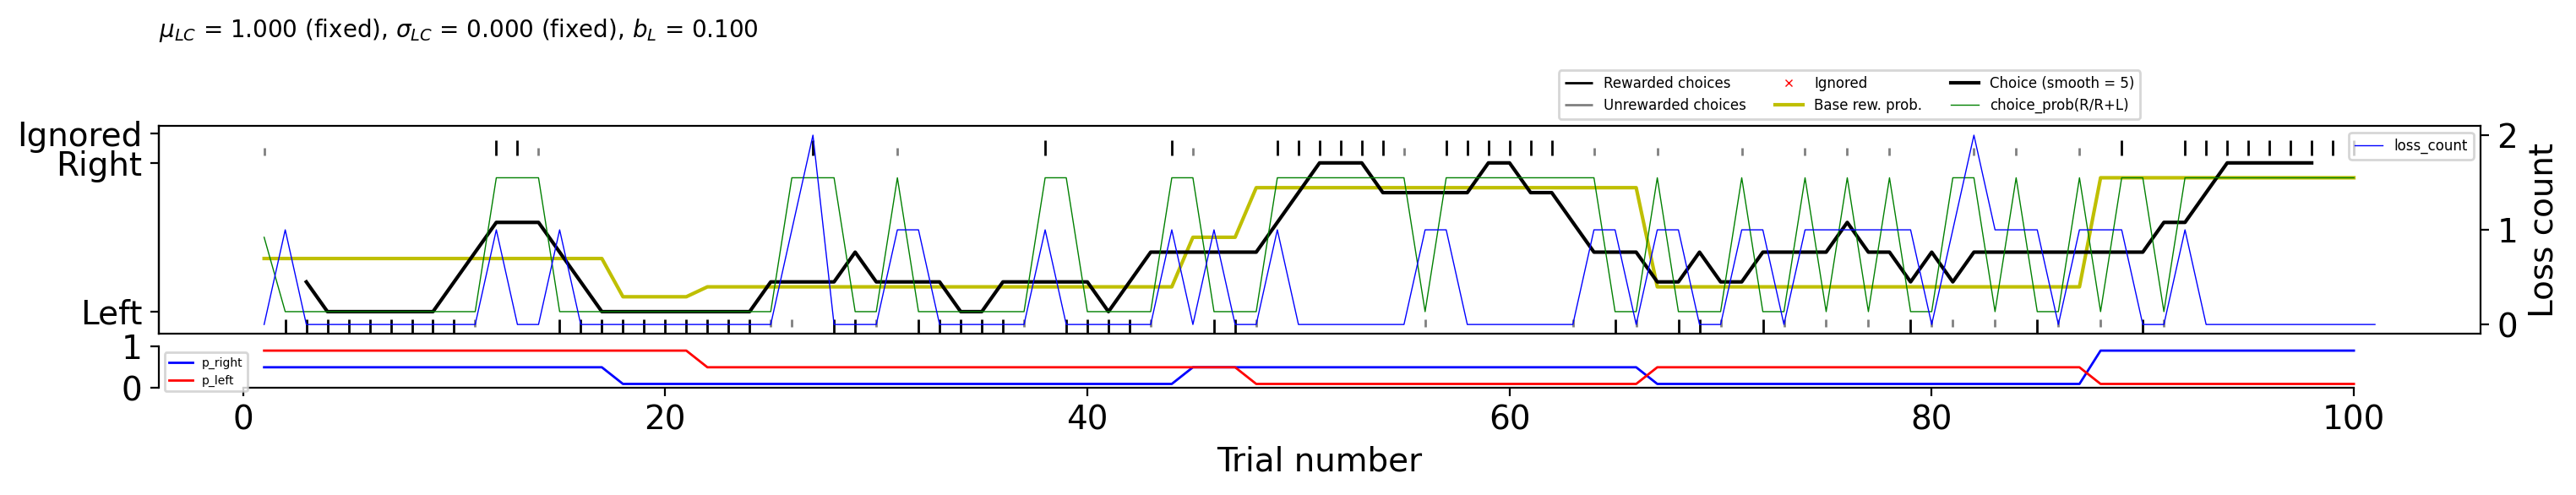

In [31]:
# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

Notice the `loss_count` trace

In [32]:
# Fit the model to recover parameters
forager.fit(
    choice_history,
    reward_history,
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-08-12 13:44:09,954 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 18.940234943530868
differential_evolution step 2: f(x)= 18.507118786629732
differential_evolution step 3: f(x)= 18.507118786629732
differential_evolution step 4: f(x)= 18.507118786629732
differential_evolution step 5: f(x)= 18.507118786629732
differential_evolution step 6: f(x)= 18.505850969837766
Polishing solution with 'L-BFGS-B'


In [33]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
print(fit_names)
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

['biasL']
Num of trials: 100
Fitted parameters: ['biasL']
Ground truth: ['0.1000']
Fitted:       ['0.1304']
Likelihood-Per-Trial: 0.8310634241202992
Prediction accuracy full dataset: 0.93



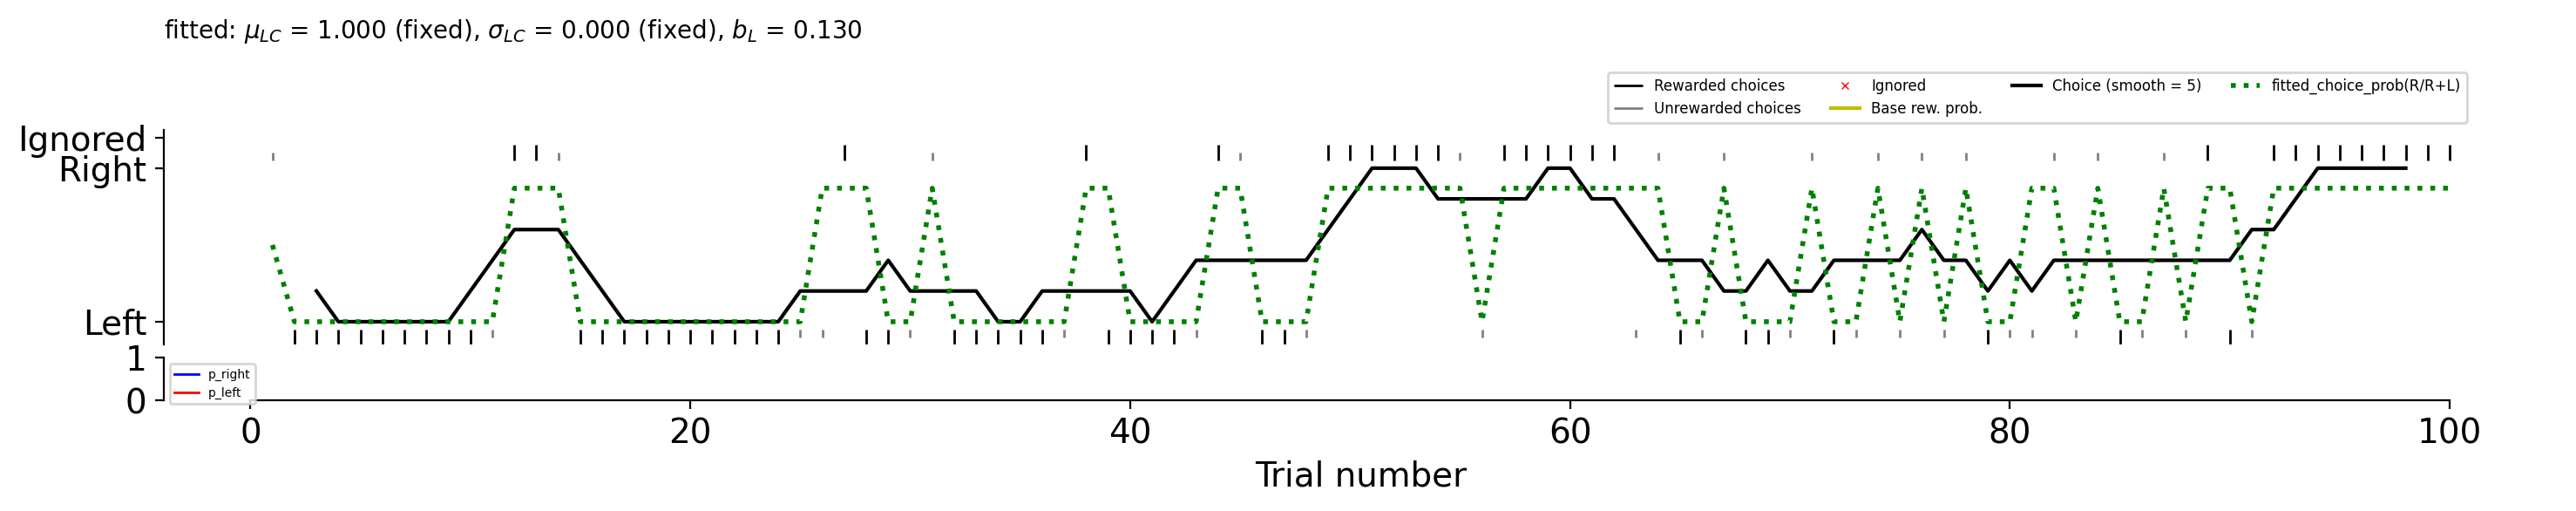

In [34]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

### Recover parameter sets

By simulating agents with a range of parameter combinations from a fixed model type, we can assess the identifiability and robustness of the model—determining whether the fitting procedure can reliably recover true parameters across diverse scenarios. This process is crucial for validating that the model is not only flexible enough to capture behavioral variability.

To do this, we can follow these steps: 

- Choose the model(s) $M_1, M_2, \dots$ you want to test (e.g. Rescorla–Wagner, WSLS).  
- For each model, define parameter ranges: e.g. Learning rate $\alpha \in [0.05, 0.9]$, inverse temperature $\sigma \in [0.5, 10]$  

- Simulate Behavioral Data: for every parameter draw $\boldsymbol{\theta}^{(i)}$:  
     1. Initialize model state (e.g., $Q^k_0 = 0$).  
     2. Loop over trials $t = 1 \dots T$:  
        - Sample choice $c_t \sim p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}^{(i)}, M)$  
        - Sample outcome $r_t$ from the task’s reward schedule  
        - Update model states.  

- Compute Diagnostic Summaries such as choice-probability curves, use these summaries to confirm the simulated behavior matches the qualitative patterns you expect.

- Parameter-Recovery Check: fit the same model back to the simulated data. Good recovery (slope ≈ 1, $R^2$ high) indicates your model + fitting procedure can, in principle, retrieve true parameters.



#### Example: Loss Counting Model 

Generate multiple LossCounting model with different parameter sets. `fit_para_recovery` is a pre-packed function to do this

<details>
<summary><b> function fit_para_recovery explained </b></summary>

**Overview**
Generate fake data with given parameter and run model fitting to the fake data

**Inputs**
- `forager`:
     - str, model type identifier: e.g. `LossCounting` or `RW1972_softmax`, full list refer to the [dict] `forager_params` defined below, which maps forager names to their parameter lists. `learn_rate` has to be included for `RW1972` kind of model
- `para_names`: list[str]
- `para_bounds`: list[str], bound of optization range 
- `para_scales`: scales to display the plot (only for visualization)
- `true_paras`: numpy array 
- `fit_method`: str, Optimization algorithm: e.g. `DE` or `L-BFGS-B`

**Outputs**
- `true_paras`:	numpy.ndarray, (n_parameters, n_models), True parameter values used for simulation
- `fitted_paras`:numpy.ndarray, (n_parameters, n_models), Recovered parameter values from fitting

</details>

In [40]:
# Mapping between forager names and their parameters
forager_params = {
    'RW1972_softmax': ['learn_rate', 'softmax_temperature', 'biasL', 'forget_rate'],
    'RW1972_epsi': ['epsilon', 'learn_rate', 'biasL', 'forget_rate'],
    'LossCounting': ['loss_count_threshold_mean', 'loss_count_threshold_std', 'biasL', 'choice_kernel_step_size', 'choice_kernel_relative_weight'],
}

In [41]:
# choose a model and generate a set of ground truth parameters 

n_trials = 400
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,2]] # specify parameter range 
true_paras = generate_true_paras(para_bounds=[[0,0],[30,1]], n_models = 10, method = 'random_uniform')

#visualization of the true parameters
# fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
# axs.plot(true_paras[0,:], true_paras[1,:], 'o')
# axs.set_xlabel('loss_count_threshold_mean')
# axs.set_ylabel('loss_count_threshold_std')
# axs.set_title('True parameters')

4


Parameter Recovery, LossCounting: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]
/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:2124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(true_paras[para_2d[0],n], true_paras[para_2d[1],n],'ok', markersize=11, fillstyle='none', c = colors[n], label = 'True' if not legend_plotted else '',alpha=.7)
/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:2125: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(fitted_paras[para_2d[0],n], fitted_paras[para_2d[1],n],'ok', markersize=7, c = colors[n], label = 'Fitted' if not legend_plotted else '',alpha=.7)


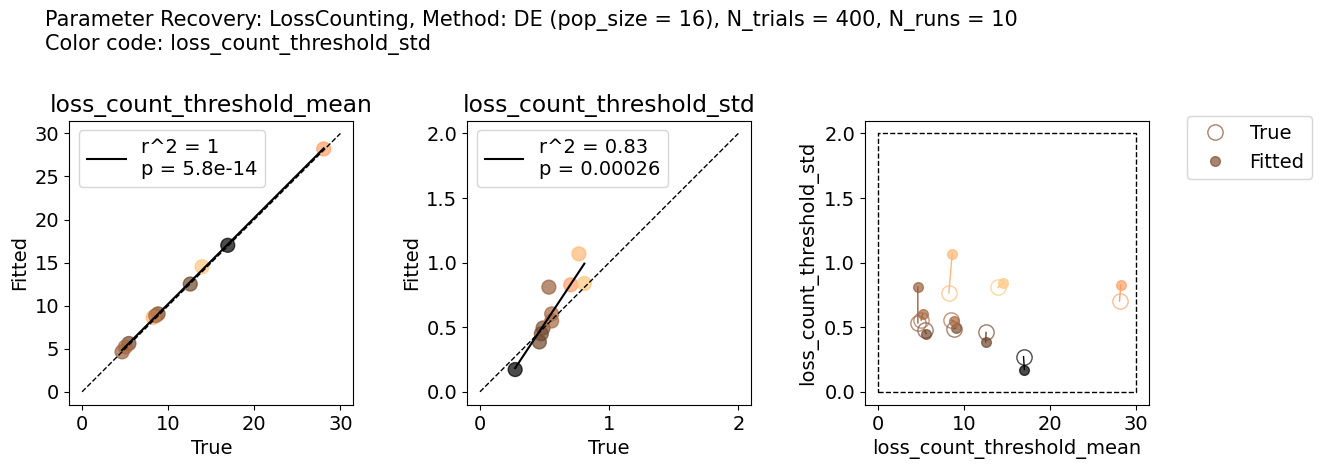

In [42]:
# fit model to recover parameters (this function takes some time to compute)

# set the number of workers
n_worker = int(mp.cpu_count()/2)
pool = mp.Pool(processes = n_worker)
print(n_worker)
    
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

Compute the loss likelihood landscape for different parameter combinations. This can be used to examine how different parameters contribute the behavioral output. 

Fitting using L-BFGS-B (n_x0s = 8), pool = True...
  True para: [10  1]
Fitted para: [10.067  1.   ]
km = 2, AIC = 171.753, BIC = 179.168
      LPT_AIC = 0.752, LPT_BIC = 0.743


/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:4355: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


the shape of x is  (297,)
the shape of y is  (297,)


LL_surface pair #0: 100%|██████████| 400/400 [00:02<00:00, 171.21it/s]


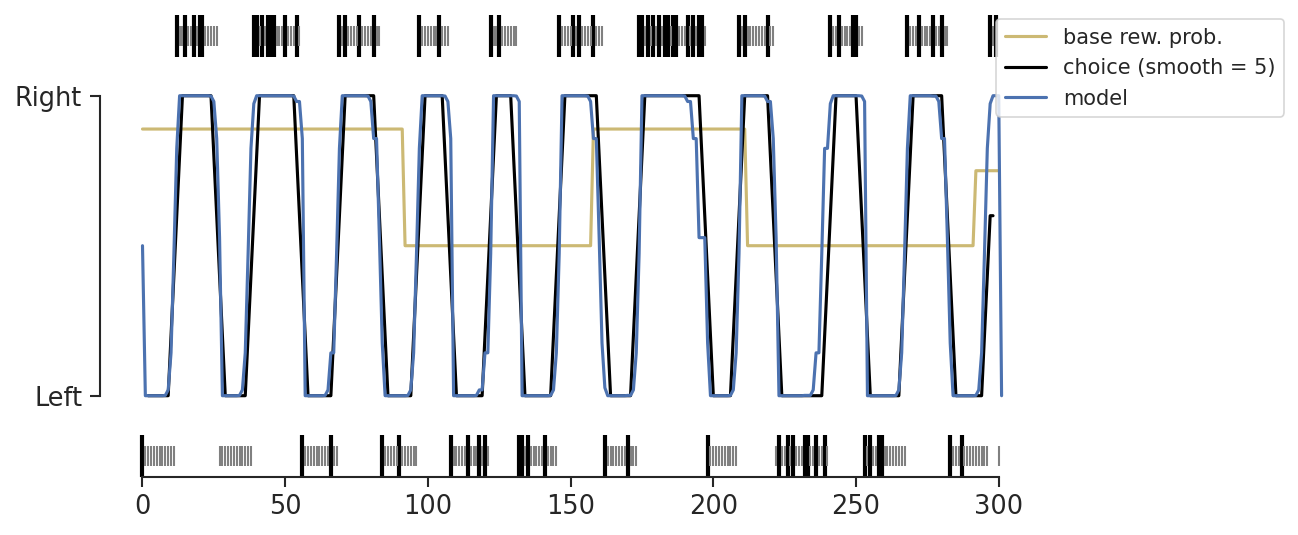

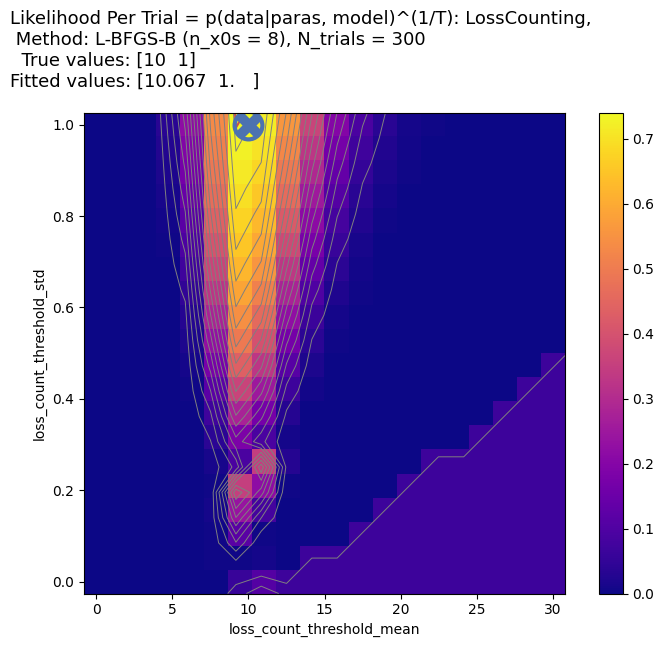

In [43]:
# visualize behavior of the ground truth agent and the fitted agent 
n_trials = 300
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,1]]
true_para = [10,1]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool=pool)

#### Example: Rescola-Wagner with Softmax 

Parameter Recovery, RW1972_softmax: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]
/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:2124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(true_paras[para_2d[0],n], true_paras[para_2d[1],n],'ok', markersize=11, fillstyle='none', c = colors[n], label = 'True' if not legend_plotted else '',alpha=.7)
/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:2125: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(fitted_paras[para_2d[0],n], fitted_paras[para_2d[1],n],'ok', markersize=7, c = colors[n], label = 'Fitted' if not legend_plotted else '',alpha=.7)


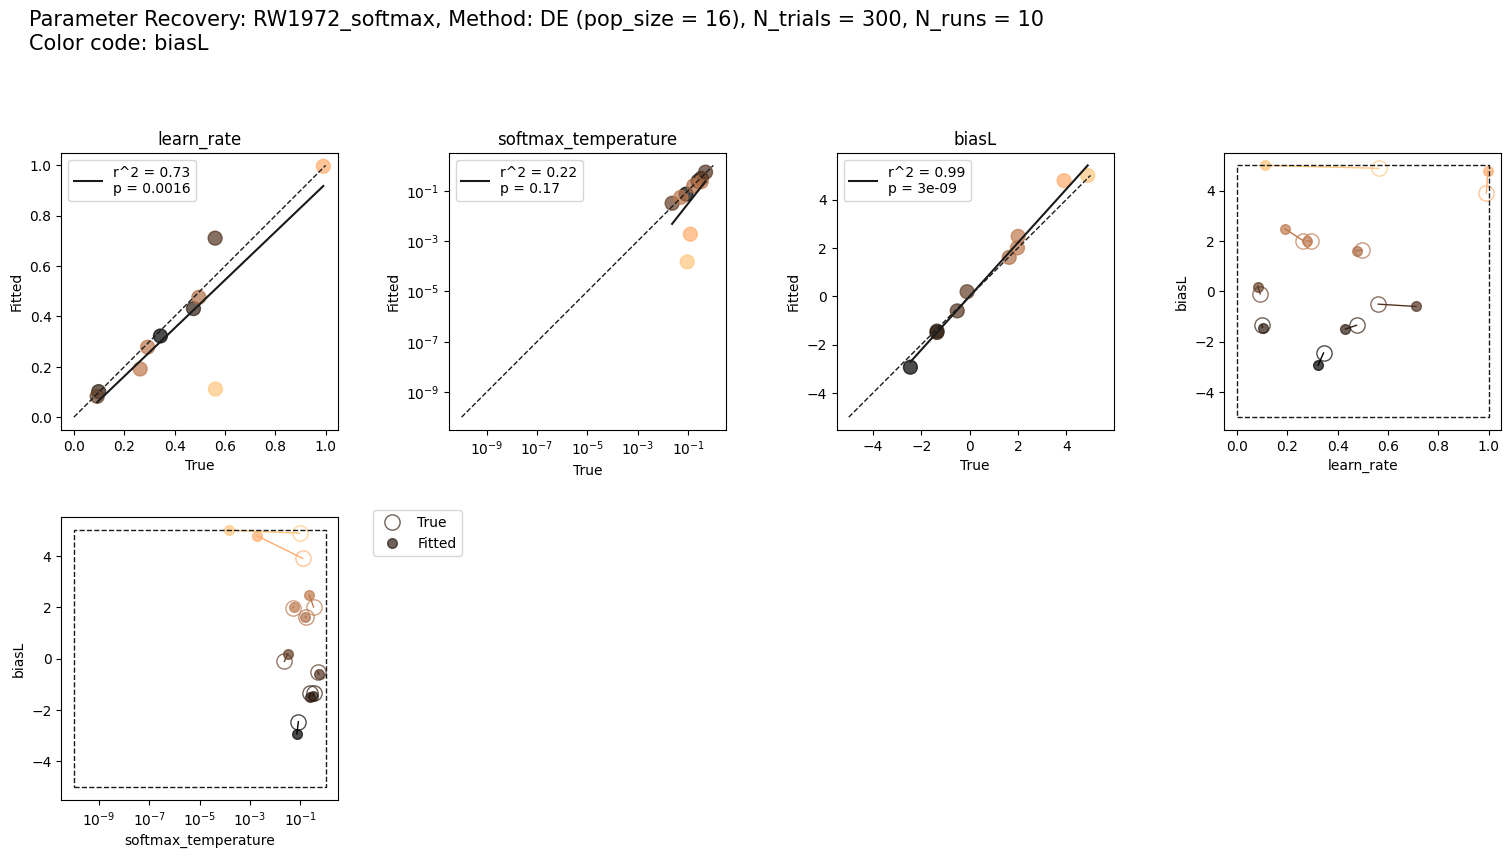

In [44]:
n_trials = 300

forager = 'RW1972_softmax'
para_names = ['learn_rate','softmax_temperature','biasL']
para_scales = ['linear','log', 'linear']
para_bounds = [[0,1e-10,-5],
               [1, 1, 5]]

n_models = 10
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        np.random.uniform(-5, 5, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,2],[1,2]],
              fit_method = 'DE', pool = pool); 


## Model Recovery
   - Fit *all* candidate models to each surrogate dataset.  
   - Evaluate with AIC or BIC:  
     $ \text{AIC} = -2\log\hat{L} + 2k,\quad \text{BIC} = -2\log\hat{L} + k\log T. $. Where $\hat{L}$ is the maximum likelihood, $k$ is the number of free parameters in the model, $T$ is the number of data points (e.g., trials). Lower AIC/BIC means better model. 
   - Ideally, the data generated by model $M_i$ is most strongly favored when you fit $M_i$ (diagonal dominance in a confusion matrix).

Once you’ve fit several models to the same dataset, the next step is to determine which model provides the best explanation of the behavior.


#### Approximate Posterior over Models  (need Han's explanation)

The relative probability of a model given the data can then be approximated as:

$$p(M \mid \text{data}) \propto \exp\left(-\frac{\text{IC}}{2}\right)$$

This allows us to derive:
- Relative log-likelihood: $\log_{10} \frac{p(\text{model})}{p(\text{best model})}$
- Model weights: normalized probabilities over models


In [46]:
# List of available models and parameters
# Default models (reordered with hindsight results). Use the format: [forager, [para_names], [lower bounds], [higher bounds]]
MODELS = [
            # No bias (1-8)
            ['LossCounting', ['loss_count_threshold_mean', 'loss_count_threshold_std'], [0,0], [40,10]],                   
            ['RW1972_epsi', ['learn_rate', 'epsilon'],[0, 0],[1, 1]],
            ['LNP_softmax',  ['tau1', 'softmax_temperature'], [1e-3, 1e-2], [100, 15]],                 
            ['LNP_softmax', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature'],[1e-3, 1e-1, 0, 1e-2],[15, 40, 1, 15]],                 
            ['RW1972_softmax', ['learn_rate', 'softmax_temperature'],[0, 1e-2],[1, 15]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature'],[0, 0, 1e-2],[1, 1, 15]],
            ['Bari2019', ['learn_rate', 'forget_rate', 'softmax_temperature'],[0, 0, 1e-2],[1, 1, 15]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate', 'softmax_temperature'],[0, 0, 0, 1e-2],[1, 1, 1, 15]],
            
            # With bias (9-15)
            ['RW1972_epsi', ['learn_rate', 'epsilon', 'biasL'],[0, 0, -0.5],[1, 1, 0.5]],
            ['LNP_softmax',  ['tau1', 'softmax_temperature', 'biasL'], [1e-3, 1e-2, -5], [100, 15, 5]],                 
            ['LNP_softmax', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature', 'biasL'],[1e-3, 1e-1, 0, 1e-2, -5],[15, 40, 1, 15, 5]],                 
            ['RW1972_softmax', ['learn_rate', 'softmax_temperature', 'biasL'],[0, 1e-2, -5],[1, 15, 5]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature', 'biasL'],[0, 0, 1e-2, -5],[1, 1, 15, 5]],
            ['Bari2019', ['learn_rate', 'forget_rate', 'softmax_temperature', 'biasL'],[0, 0, 1e-2, -5],[1, 1, 15, 5]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate', 'softmax_temperature', 'biasL'],[0, 0, 0, 1e-2, -5],[1, 1, 1, 15, 5]],
            
            # With bias and choice kernel (16-21)
            ['LNP_softmax_CK',  ['tau1', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'], 
                             [1e-3, 1e-2, -5, 0, 1e-2], [100, 15, 5, 1, 20]],                 
            ['LNP_softmax_CK', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [1e-3, 1e-1, 0, 1e-2, -5, 0, 1e-2],[15, 40, 1, 15, 5, 1, 20]],                 
            ['RW1972_softmax_CK', ['learn_rate', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 1e-2, -5, 0, 1e-2],[1, 15, 5, 1, 20]],
            ['Hattori2019_CK', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 15, 5, 1, 20]],
            ['Bari2019_CK', ['learn_rate', 'forget_rate', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 15, 5, 1, 20]],
            ['Hattori2019_CK', ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                               [0, 0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 1, 15, 5, 1, 20]],
            # ['Hattori2019_CK', ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
            #                    [0, 0, 0, 1e-2, -5, 1, 1e-2],[1, 1, 1, 15, 5, 1, 20]],  # choice_step_size fixed at 1 --> Bari 2019: only the last choice matters
            
         ]

### Example: ground truth model is Loss Counting

<details>
<summary><b> function BanditModelComparison explained </b></summary> 

**Overview**

The `BanditModelComparison` class is a comprehensive tool for comparing multiple foraging models on the same behavioral data. It provides a unified interface for fitting, evaluating, and comparing different computational models of decision-making behavior in multi-armed bandit tasks.

**Inputs:**
- `choice_history`: Array of choices made by the subject (shape: [1, n_trials])
- `reward_history`: Array of rewards received (shape: [1, n_trials])
- `p_reward`: Optional reward probability schedule for plotting/validation
- `session_num`: Optional session identifier for pooling across multiple sessions
- `models`: List of models to compare (see Model Specification below)

**Model Specification Options:**
1. `None`: Uses all pre-defined models from `MODELS` list
2. List of integers: Selects models by index from pre-defined list (e.g., `[1, 3, 5]`)
3. Custom model list: Direct specification of model parameters

**Core Functions**

1. Model Fitting `fit()`

Parameters:
- `fit_method`: Optimization algorithm ('DE' for differential evolution)
- `fit_settings`: Dictionary of optimization parameters
- `pool`: Multiprocessing pool for parallel fitting
- `if_verbose`: Whether to print progress information
- `plot_predictive`: Which models to plot predictive traces for

Output:
- `self.results`: Pandas DataFrame with fitting results for all models
- `self.results_sort`: Results sorted by AIC (best model first)

2. Cross-Validation `cross_validate()`

3. Visualization Methods

`plot_predictive_choice()`
- Plots predictive choice probability traces for fitted models
- Shows how well each model predicts the subject's choices over time

`plot()`
- Creates comprehensive model comparison plots
- Includes AIC/BIC comparisons, parameter estimates, and model weights


**Model Comparison Metrics**

1. AIC (Akaike Information Criterion):
- Balances model fit with complexity
- Lower values indicate better models
- Formula: AIC = 2K - 2ln(L), where K = number of parameters, L = likelihood

2. BIC (Bayesian Information Criterion):
- More stringent penalty for model complexity
- Lower values indicate better models
- Formula: BIC = ln(n)K - 2ln(L), where n = number of observations

3. Model Weight:
- Normalized relative likelihood (sums to 1)
- Can be interpreted as posterior probability of each model


In [47]:
choice_history, reward_history, p_reward = generate_fake_data('LossCounting', ['loss_count_threshold_mean','loss_count_threshold_std'], [10,0])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,5])

=== Model Comparison ===
Methods = DE, {'DE_pop_size': 16}, pool = True
Model 1/3:    LossCounting, Km = 2 ...

 AIC = 79.069, BIC = 88.8865 (done in 6.36 secs)
Model 2/3:     RW1972_epsi, Km = 2 ... AIC = 1206.08, BIC = 1215.89 (done in 3.17 secs)
Model 3/3:  RW1972_softmax, Km = 2 ... AIC = 970.811, BIC = 980.628 (done in 2.87 secs)
the shape of x is  (997,)
the shape of y is  (997,)


/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:4355: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


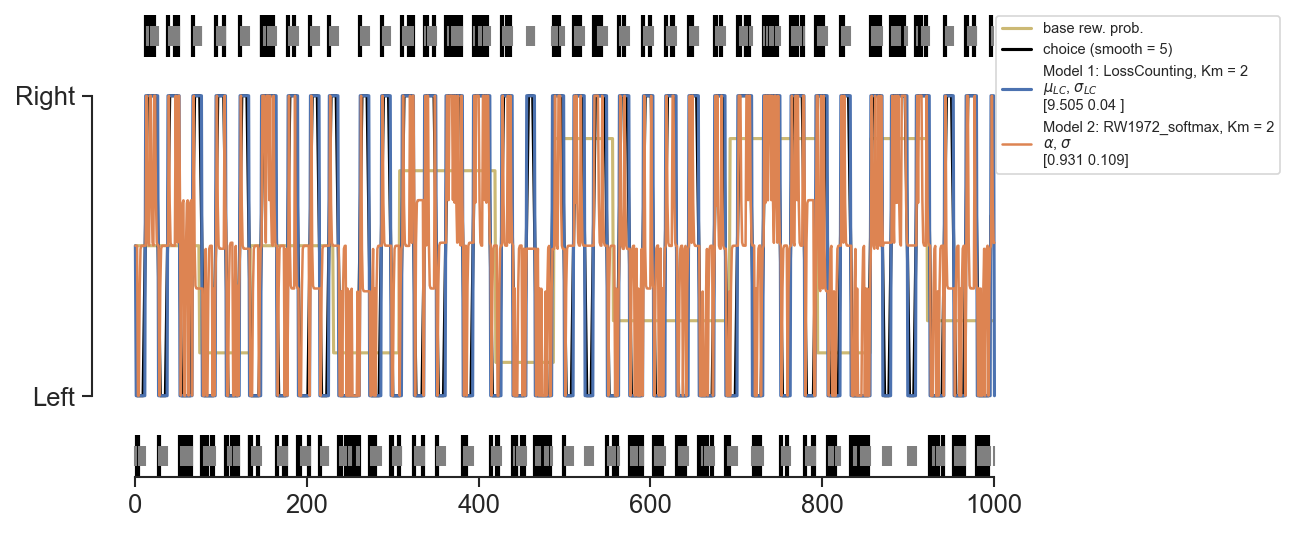

In [48]:
model_comparison.fit(pool = pool, plot_predictive=[1,2])  # Plot predictive traces for the 1st, 2nd, and 3rd models

In [52]:
model_comparison.results_sort.loc[:, ['model', 'Km', 'AIC', 'BIC', 'LPT', 'para_names', 'para_notation', 'para_bounds', 'para_fitted']]

,model,Km,AIC,BIC,LPT,para_names,para_notation,para_bounds,para_fitted
1,LossCounting,2,79.069017,88.886527,0.963197,"[loss_count_threshold_mean, loss_count_threshold_std]","$\mu_{LC}$, $\sigma_{LC}$","[[0, 0], [40, 10]]","[9.505, 0.04]"
3,RW1972_softmax,2,970.810918,980.628427,0.616978,"[learn_rate, softmax_temperature]","$\alpha$, $\sigma$","[[0, 0.01], [1, 15]]","[0.931, 0.109]"
2,RW1972_epsi,2,1206.077242,1215.894752,0.548571,"[learn_rate, epsilon]","$\alpha$, $\epsilon$","[[0, 0], [1, 1]]","[0.544, 0.599]"


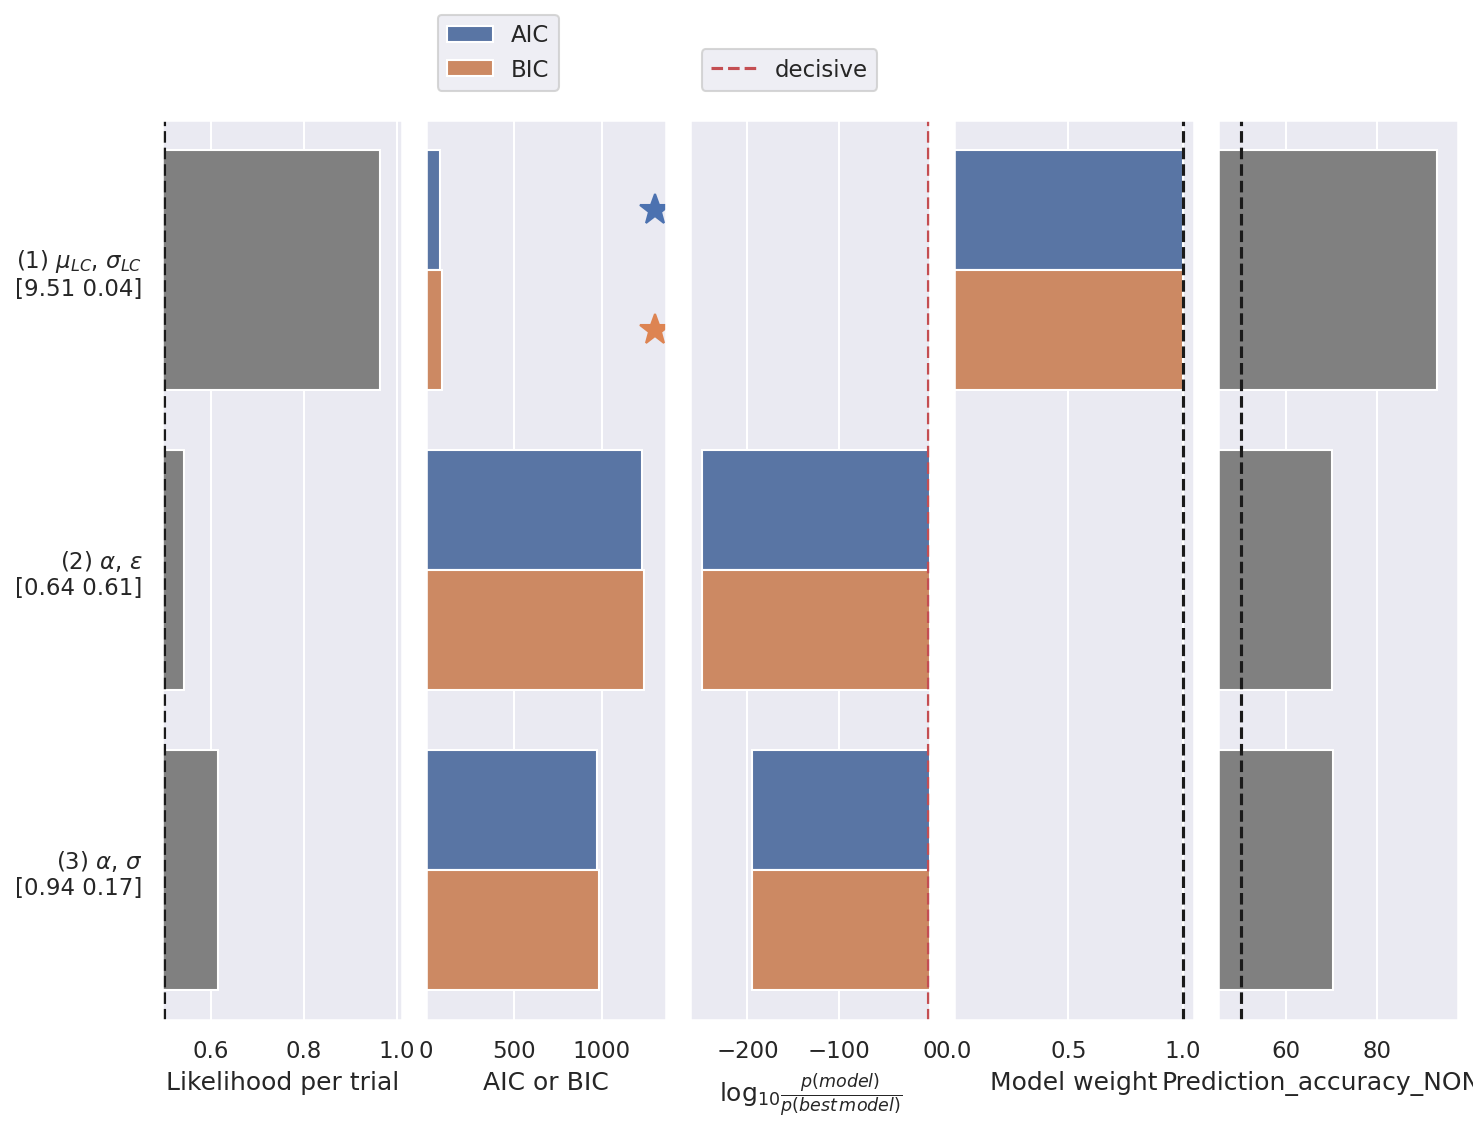

In [31]:
model_comparison.plot()

### Example: Rescorla Wagner Softmax

=== Model Comparison ===
Methods = DE, {'DE_pop_size': 16}, pool = True
Model 1/3:    LossCounting, Km = 2 ... AIC = 1297.6, BIC = 1307.41 (done in 4.55 secs)
Model 2/3:     RW1972_epsi, Km = 2 ... AIC = 1073.4, BIC = 1083.22 (done in 3.1 secs)
Model 3/3:  RW1972_softmax, Km = 2 ... AIC = 978.694, BIC = 988.511 (done in 2.97 secs)
the shape of x is  (997,)
the shape of y is  (997,)


/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:4355: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


,model,Km,AIC,log10_BF_AIC,model_weight_AIC,BIC,log10_BF_BIC,model_weight_BIC,para_notation,para_fitted
3,RW1972_softmax,2,978.69,-0.00,1.0,988.51,-0.00,1.0,"$\alpha$, $\sigma$","[0.272, 0.186]"
2,RW1972_epsi,2,1073.40,-20.57,0.0,1083.22,-20.57,0.0,"$\alpha$, $\epsilon$","[0.292, 0.444]"
1,LossCounting,2,1297.60,-69.25,0.0,1307.41,-69.25,0.0,"$\mu_{LC}$, $\sigma_{LC}$","[7.333, 10.0]"


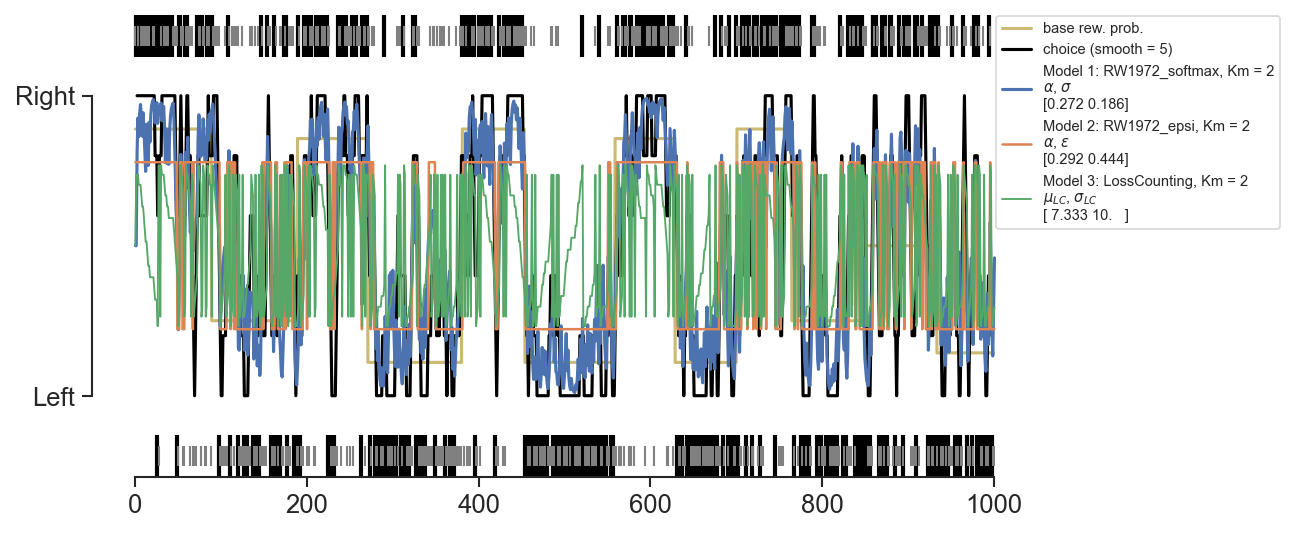

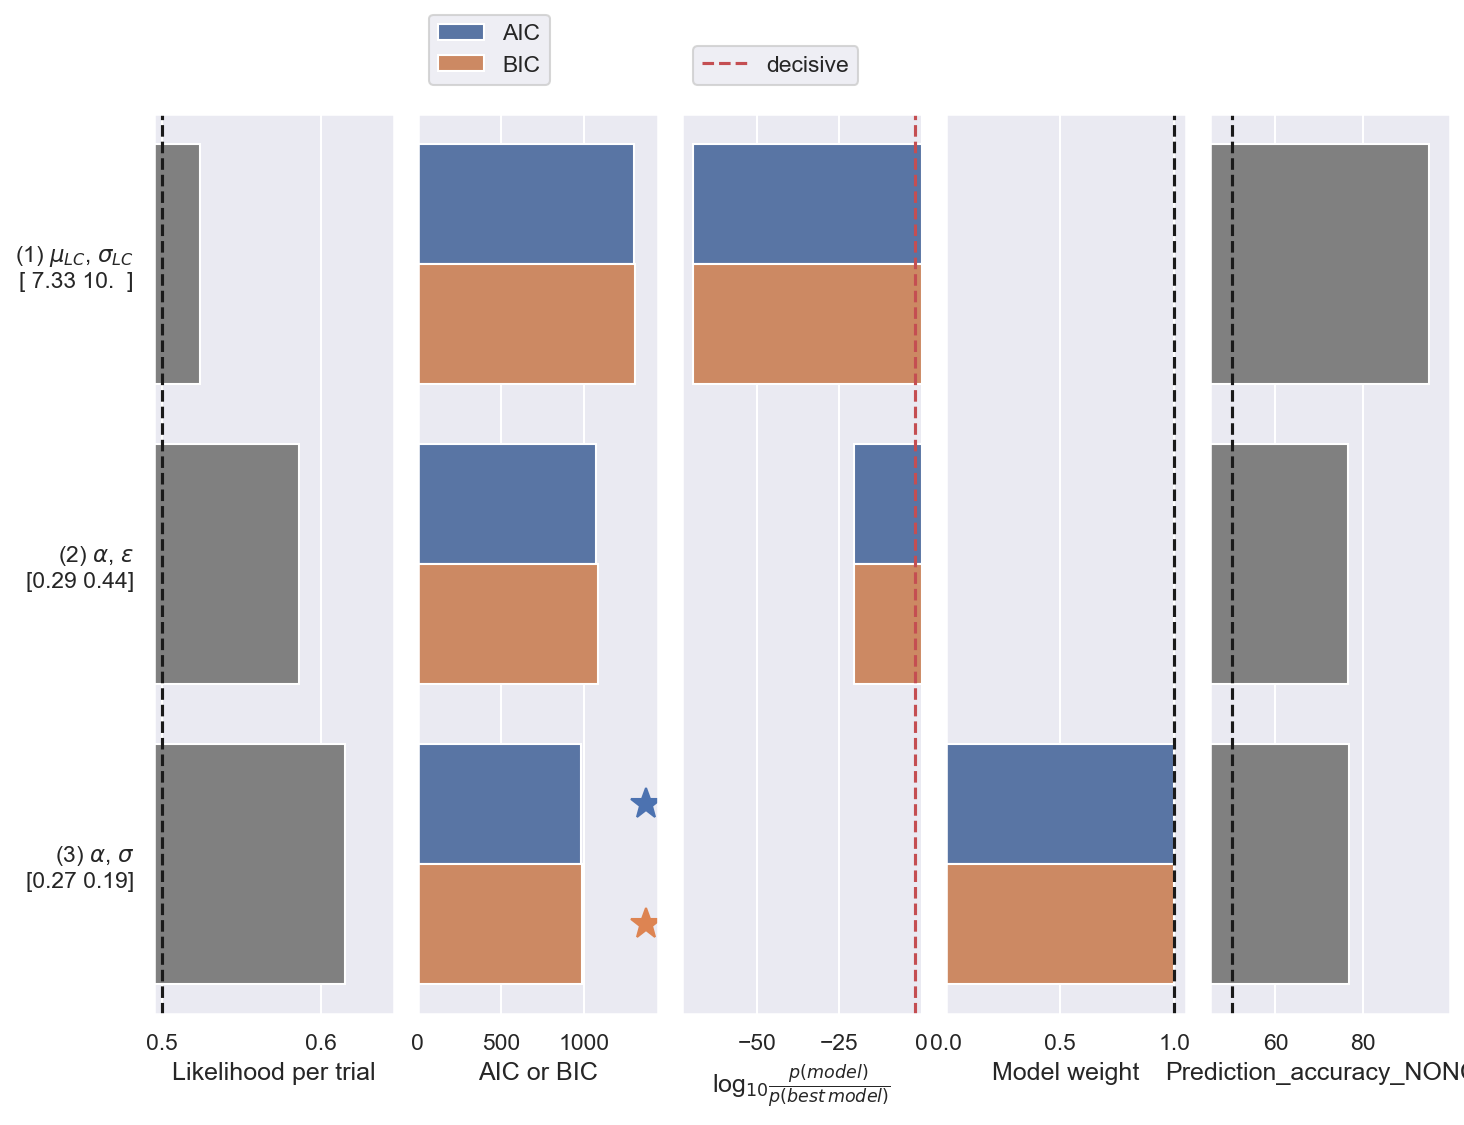

In [53]:
choice_history, reward_history, p_reward = generate_fake_data('RW1972_softmax', ['learn_rate','softmax_temperature'], [0.3,0.2])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,5])
model_comparison.fit(pool = pool, plot_predictive=[1,2,3]) # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

## References

- Wilson, R. C., & Collins, A. G. (2019). Ten simple rules for the computational modeling of behavioral data. *eLife*, 8, e49547. https://doi.org/10.7554/eLife.49547  
- Palminteri, S., Wyart, V., & Koechlin, É. (2017). The importance of falsification in computational cognitive modeling. *Trends in Cognitive Sciences*, 21(6), 425–433. https://doi.org/10.1016/j.tics.2017.03.011


# Real Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from aind_analysis_arch_result_access.han_pipeline import get_session_table
from pynwb import NWBHDF5IO
from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask, UncoupledBlockTask
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_dynamic_foraging_basic_analysis import plot_foraging_session

In [54]:
LOCAL_NWB_TMP = "/data/foraging_nwb_bonsai"

def get_nwb_from_local_tmp(session_id):
    """Get NWB file from session_id.

    Overwrite this function to get NWB file from other places.

    Parameters
    ----------
    session_id : _type_
        _description_
    """
    io = NWBHDF5IO(f"{LOCAL_NWB_TMP}/{session_id}.nwb", mode="r")
    nwb = io.read()
    return nwb


def get_history_from_nwb(nwb):
    """Get choice and reward history from nwb file
    
    #TODO move this to aind-behavior-nwb-util
    """

    df_trial = nwb.trials.to_dataframe()

    autowater_offered = (df_trial.auto_waterL == 1) | (df_trial.auto_waterR == 1)
    choice_history = df_trial.animal_response.map({0: 0, 1: 1, 2: np.nan}).values
    reward_history = df_trial.rewarded_historyL | df_trial.rewarded_historyR
    p_reward = [
        df_trial.reward_probabilityL.values,
        df_trial.reward_probabilityR.values,
    ]
    random_number = [
        df_trial.reward_random_number_left.values,
        df_trial.reward_random_number_right.values,
    ]

    baiting = False if "without baiting" in nwb.protocol.lower() else True

    return (
        baiting,
        choice_history,
        reward_history,
        p_reward,
        autowater_offered,
        random_number,
    )


In [ ]:
df = get_session_table(if_load_bpod=False)
criteria = "subject_id=='792292' and current_stage_actual == 'GRADUATED'"
df.query(criteria).shape

In [ ]:
df.query(criteria).head()

In [ ]:
session_id = '792292_2025-07-07_14-11-45'
nwb = get_nwb_from_local_tmp(session_id=session_id)
df_trial = nwb.trials.to_dataframe()
df_trial.head()

## Task description

Some important columns:
- bait_left, bait_right
- animal_response
- rewarded_historyL
- rewarded_historyR
- reward_probabilityL
- reward_probabilityR

In [ ]:
baiting, choice_history, reward_history,_,autowater_offered,random_number = get_history_from_nwb(nwb)

In [55]:
ignored = np.isnan(choice_history)
choice_history = choice_history[~ignored]
reward_history = reward_history[~ignored].to_numpy()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 2 but size of corresponding boolean axis is 1